# Import

In [3]:
import gymnasium as gym
import numpy as np

import PIL.Image
import tensorflow as tf


from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

from collections import deque, namedtuple

In [4]:
import utils
from utils import update_target_network

In [5]:
# Create the environment
env = gym.make("LunarLander-v3", render_mode='rgb-array')

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

/home/slam/miniconda3/lib/python3.9/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb-array' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


### For checking

In [27]:
state_size = env.observation_space.shape
num_actions = env.action_space.shape

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: ()


In [30]:
num_actions = env.action_space.n
print(num_actions)


4


So, state shape = 8; number of actions = 4\

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [7]:
# Reset the environment and get the initial state.
initial_state = env.reset()

# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, terminated, truncated, info = env.step(action)

In [8]:
print (initial_state)
print ("after doing action ", action, " the next state is: " )
print (next_state)

(array([-0.00377645,  1.4207162 , -0.38253075,  0.4353712 ,  0.00438278,
        0.0866489 ,  0.        ,  0.        ], dtype=float32), {})
after doing action  0  the next state is: 
[-0.00755339  1.4299338  -0.3820129   0.40965584  0.0086646   0.08564439
  0.          0.        ]


In [9]:
with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", terminated)
    print("Info:", info)

Initial State: (array([-0.004, 1.421, -0.383, 0.435, 0.004, 0.087, 0.000, 0.000],
      dtype=float32), {})
Action: 0
Next State: [-0.008 1.430 -0.382 0.410 0.009 0.086 0.000 0.000]
Reward Received: 0.5899814917771096
Episode Terminated: False
Info: {}


## Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

### Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Notice that this forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:

$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

In [10]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [25]:
# for check

print(state_size)
# state_size is tuple
print(num_actions)



(8,)
()


In [31]:
# UNQ_C1
# GRADED CELL
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ###
    Input(shape= state_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ### END CODE HERE ###
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ###
    Input(shape= state_size ),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ### END CODE HERE ###
    ])

### START CODE HERE ###
optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

### Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [12]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [13]:
print(experience._fields)

('state', 'action', 'reward', 'next_state', 'done')


## 7 - Deep Q-Learning Algorithm with Experience Replay

Now that we know all the techniques that we are going to use, we can put them togther to arrive at the Deep Q-Learning Algorithm With Experience Replay.
<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>

### Exercise 2

In this exercise you will implement line ***12*** of the algorithm outlined in *Fig 3* above and you will also compute the loss between the $y$ targets and the $Q(s,a)$ values. In the cell below, complete the `compute_loss` function by setting the $y$ targets equal to:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Here are a couple of things to note:

* The `compute_loss` function takes in a mini-batch of experience tuples. This mini-batch of experience tuples is unpacked to extract the `states`, `actions`, `rewards`, `next_states`, and `done_vals`. You should keep in mind that these variables are *TensorFlow Tensors* whose size will depend on the mini-batch size. For example, if the mini-batch size is `64` then both `rewards` and `done_vals` will be TensorFlow Tensors with `64` elements.


* Using `if/else` statements to set the $y$ targets will not work when the variables are tensors with many elements. However, notice that you can use the `done_vals` to implement the above in a single line of code. To do this, recall that the `done` variable is a Boolean variable that takes the value `True` when an episode terminates at step $j+1$ and it is `False` otherwise. Taking into account that a Boolean value of `True` has the numerical value of `1` and a Boolean value of `False` has the numerical value of `0`, you can use the factor `(1 - done_vals)` to implement the above in a single line of code. Here's a hint: notice that `(1 - done_vals)` has a value of `0` when `done_vals` is `True` and a value of `1` when `done_vals` is `False`.

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use the already imported package `MSE`:
```python
from tensorflow.keras.losses import MSE
```

### Calculate loss

In [14]:


def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ###
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    ### START CODE HERE ###
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ###

    return loss

## Update the Network Weights

We will use the `agent_learn` function below to implement lines ***12 -14*** of the algorithm outlined in [Fig 3](#7). The `agent_learn` function will update the weights of the $Q$ and target $\hat Q$ networks using a custom training loop. Because we are using a custom training loop we need to retrieve the gradients via a `tf.GradientTape` instance, and then call `optimizer.apply_gradients()` to update the weights of our $Q$-Network. Note that we are also using the `@tf.function` decorator to increase performance. Without this decorator our training will take twice as long. If you would like to know more about how to increase performance with `@tf.function` take a look at the [TensorFlow documentation](https://www.tensorflow.org/guide/function).

The last line of this function updates the weights of the target $\hat Q$-Network using a [soft update](#6.1). If you want to know how this is implemented in code we encourage you to take a look at the `utils.update_target_network` function in the `utils` module.

In [33]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

<a name="9"></a>
## 9 - Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils.get_action` function in the `utils` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`.


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have at least `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes.

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

**Note:** With this notebook's default parameters, the following cell takes between 10 to 15 minutes to run.

In [36]:
state, infor = env.reset()
state_qn = np.expand_dims(state, axis=0)

In [37]:
import time
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state, infor = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        # next_state, reward, terminated, truncated, _ = env.step(action)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -160.14
Episode 200 | Total point average of the last 100 episodes: -94.616
Episode 300 | Total point average of the last 100 episodes: -54.96
Episode 400 | Total point average of the last 100 episodes: 51.372
Episode 500 | Total point average of the last 100 episodes: 131.49
Episode 600 | Total point average of the last 100 episodes: 180.75
Episode 622 | Total point average of the last 100 episodes: 199.99

Episode 623 | Total point average of the last 100 episodes: 200.42

Environment solved in 623 episodes!

Total Runtime: 1165.94 s (19.43 min)


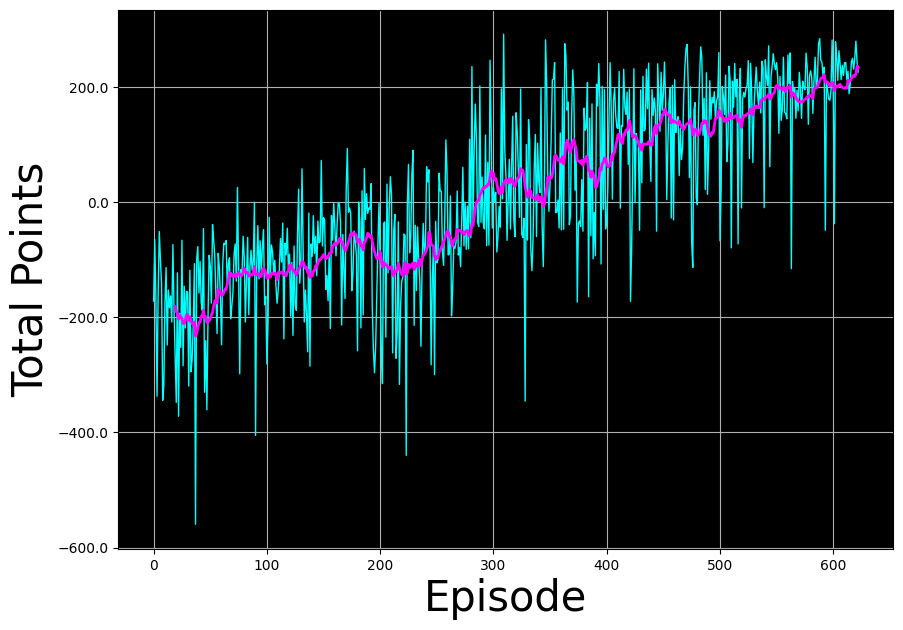

In [38]:
# Plot the point history
utils.plot_history(total_point_history)

In [41]:
env = gym.make("LunarLander-v3", render_mode='rgb_array')

In [42]:
def create_video(filename, env, q_network, fps=30):
    import imageio
    import numpy as np

    with imageio.get_writer(filename, fps=fps) as video:
        state, _ = env.reset()
        frame = env.render()
        video.append_data(frame)

        done = False
        while not done:
            state_qn = np.expand_dims(state, axis=0)
            q_values = q_network(state_qn, training=False)
            action = np.argmax(q_values.numpy()[0])

            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frame = env.render()
            video.append_data(frame)


In [43]:
filename = "/media/slam/Storage500GB/Minh-Khang-Workspace/week3/robot_learning/lunar_lander/lunar_pro.mp4"
create_video (filename, env,q_network)

In [ ]:
from IPython.display import Image
filename = 
display(Image(filename))